### GPU Available?

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6797634698949205916
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11320098816
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16422907871819656327
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
xla_global_id: 416903419
]


### Data Pulling

In [2]:
from google.colab import drive
drive.mount('/content/drive')

path = r'/content/drive/My Drive/NCCU_Project'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

df = pd.read_csv(path + '/ETF_Raw.csv')
df=df.sort_values(['date','tic']).reset_index(drop=True)
df['date']= pd.to_datetime(df['date'])
df["DailyRet"] = 0
df["20DayRet"] = 0
df["20DayVol"] = 0
df["Z20DayRet"] = 0
df['Z20DayVol'] = 0
#df['Date']= pd.to_datetime(df['Date'])
#df_close = df[['Date', 'Index', 'Close']] 
df_close = df[['date', 'tic', 'close']] 
df_close.info()
df_close = df_close.pivot_table(index = 'date', columns = 'tic', values = 'close').dropna(axis=1)
stocks_tickers = df_close.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1196461 entries, 0 to 1196460
Data columns (total 3 columns):
 #   Column  Non-Null Count    Dtype         
---  ------  --------------    -----         
 0   date    1196461 non-null  datetime64[ns]
 1   tic     1196461 non-null  object        
 2   close   1196461 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 27.4+ MB


In [4]:
#Saving Trading Days
dates = df_close.index

#Saving Stocks
stocks = df_close.columns

# Feature Engineering

In [5]:
raw_df = df.set_index(['date' , 'tic']).unstack(level = 1).stack(level = 0).unstack()
raw_df = raw_df.dropna(axis = 1)
for stock in stocks_tickers:
  #Calculate Daily Returns
  raw_df.loc[:, (stock, 'DailyRet')] = raw_df[stock]["close"].pct_change()
  #Calculate 20-Day Returns
  raw_df.loc[:, (stock, '20DayRet')] = raw_df[stock]["close"].pct_change(20)
  #Calculate Rolling 20 day volatility 
  roller = raw_df[stock]["DailyRet"].rolling(20)
  raw_df.loc[:, (stock, '20DayVol')] = roller.std(ddof=0)
  
  '''Normalize data with the rolling 252'''
  #Normalize 20 Day Returns 
  rolling_year_ret = raw_df[stock]["20DayRet"].rolling(252)
  raw_df.loc[:, (stock, 'Z20DayRet')] = (rolling_year_ret.mean().shift(1) - raw_df[stock]['20DayRet']) / rolling_year_ret.std(ddof=0).shift(1)
  #Normalize 20 Day Volatility
  rolling_year_vol = raw_df[stock]["20DayVol"].rolling(252)
  raw_df.loc[:, (stock, 'Z20DayVol')] = (rolling_year_vol.mean().shift(1) - raw_df[stock]['20DayVol']) / rolling_year_vol.std(ddof=0).shift(1) 

raw_df.head(5)  

tic               A                                                    \
           20DayRet 20DayVol  DailyRet Z20DayRet Z20DayVol      adjcp   
date                                                                    
2012-05-10      NaN      NaN       NaN       NaN       NaN  25.962908   
2012-05-11      NaN      NaN -0.007297       NaN       NaN  25.773438   
2012-05-14      NaN      NaN -0.013942       NaN       NaN  25.414118   
2012-05-15      NaN      NaN  0.041388       NaN       NaN  26.465963   
2012-05-16      NaN      NaN -0.018514       NaN       NaN  25.975971   

tic                                               ...      ZION            \
                close  day       high        low  ...  DailyRet Z20DayRet   
date                                              ...                       
2012-05-10  28.426323  3.0  29.256081  28.383406  ...       NaN       NaN   
2012-05-11  28.218884  4.0  28.819742  28.183119  ...  0.011564       NaN   
2012-05-14  27.825464  0.0  28.211731  27.496424  ... -0.031312       NaN   
2012-05-15  28.977110  1.0  29.735336  28.905579  ... -0.021036       NaN   
2012-05-16  28.440628  2.0  29.327612  28.397711  ... -0.014151       NaN   

tic                                                                    \
           Z20DayVol      adjcp      close  day       high        low   
date                                                                    
2012-05-10       NaN  17.049673  19.889999  3.0  20.219999  19.840000   
2012-05-11       NaN  17.246830  20.120001  4.0  20.170000  19.440001   
2012-05-14       NaN  16.706791  19.490000  0.0  20.010000  19.440001   
2012-05-15       NaN  16.355339  19.080000  1.0  19.620001  18.969999   
2012-05-16       NaN  16.123896  18.809999  2.0  19.389999  18.809999   

tic                               
                 open     volume  
date                              
2012-05-10  20.000000  1600000.0  
2012-05-11  19.780001  2438800.0  
2012-05-14  19.760000  2912100.0  
2012-05-15  19.480000  3290200.0  
2012-05-16  19.170000  2219300.0  

[5 rows x 5352 columns]

In [6]:
#DROP ROWS WITH NA vals 
full_feature_dataset = raw_df.dropna(axis=0)

In [7]:
full_features = raw_df.columns.remove_unused_levels()

# Principal Component Analysis

In [8]:
full_feature_dataset.head()

tic                A                                                     \
            20DayRet  20DayVol  DailyRet Z20DayRet Z20DayVol      adjcp   
date                                                                      
2013-06-12 -0.001137  0.013908 -0.010811  0.226251  0.648358  28.998207   
2013-06-13 -0.026051  0.011165  0.012978  0.651565  1.419813  29.374552   
2013-06-14 -0.022005  0.010945 -0.011014  0.581269  1.475731  29.051031   
2013-06-17 -0.025900  0.010725  0.008636  0.644794  1.531463  29.301929   
2013-06-18 -0.033233  0.010185  0.009464  0.770989  1.674771  29.579220   

tic                                               ...      ZION            \
                close  day       high        low  ...  DailyRet Z20DayRet   
date                                              ...                       
2013-06-12  31.416309  2.0  32.067238  31.323318  ... -0.025144  0.475731   
2013-06-13  31.824034  3.0  31.874105  31.230330  ...  0.014370  0.196540   
2013-06-14  31.473534  4.0  31.881260  31.366238  ... -0.020705  0.479646   
2013-06-17  31.745352  0.0  32.095852  31.609442  ...  0.003709  0.751945   
2013-06-18  32.045780  1.0  32.052933  31.666668  ...  0.009239  0.791384   

tic                                                                           \
           Z20DayVol      adjcp      close  day   high        low       open   
date                                                                           
2013-06-12 -0.141855  23.343868  27.139999  2.0  28.09  26.950001  28.040001   
2013-06-13 -0.236659  23.679321  27.530001  3.0  27.59  27.080000  27.170000   
2013-06-14 -0.462985  23.189049  26.959999  4.0  27.77  26.830000  27.700001   
2013-06-17 -0.274384  23.275061  27.059999  0.0  27.25  26.820000  27.070000   
2013-06-18 -0.259654  23.490089  27.309999  1.0  27.42  26.870001  27.040001   

tic                    
               volume  
date                   
2013-06-12  2049100.0  
2013-06-13  1539700.0  
2013-06-14  1451400.0  
2013-06-17  2450300.0  
2013-06-18  1516300.0  

[5 rows x 5352 columns]

In [9]:
full_feature_dataset = full_feature_dataset.to_numpy()
full_feature_dataset.shape

(2244, 5352)

### Performing PCA to Extract most useful features for the dataset

In [10]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

# LSTM Stock Prediction

## Data Manipulation

In this section several steps are performed...
- Set our lookback/training window and horizon/testing window
- Create a training, validation, and test set
- Scale the data using MinMaxScaler
- Process data into arrays with ranges of dates from (lookback, t) and (t+1, horizon). T jumps by one day each time.

In [11]:
closing_prices = df_close.iloc[:full_feature_dataset.shape[0],:]

Creating train and test sets

In [12]:
from sklearn.model_selection import train_test_split
#Division of data
# df_close = df_close.to_numpy()
array_train, array_test = train_test_split(closing_prices, shuffle = False, test_size = .3)
PCA_train, PCA_test = train_test_split(full_feature_dataset, shuffle = False, test_size = .3)

In [13]:
print(closing_prices.shape)
print(array_train.shape)
print(PCA_train.shape)
print(array_test.shape)
print(PCA_test.shape)

(2244, 446)
(1570, 446)
(1570, 5352)
(674, 446)
(674, 5352)


In [14]:
from sklearn.decomposition import PCA
pc3 = PCA()
temp = pc3.fit_transform(PCA_train)

In [15]:
temp.shape

(1570, 1570)

Nearly all data is explained by 382 components

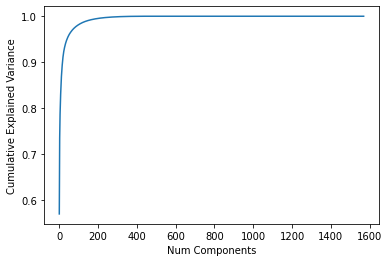

In [16]:
plt.plot(np.cumsum(pc3.explained_variance_ratio_))
plt.xlabel('Num Components')
plt.ylabel('Cumulative Explained Variance');

In [17]:
len(array_train)

1570

Scaling the Data

In [18]:
#Data with only closing prices
from sklearn.preprocessing import MinMaxScaler
scl = MinMaxScaler()
scale = MinMaxScaler()
array_train = scl.fit_transform(array_train)
array_test  = scale.fit_transform(array_test) #[0,1]

#Full features dataset; reducing dimensionality here
from sklearn.decomposition import PCA
pcTrain_scl = MinMaxScaler()
pcTest_scl  = MinMaxScaler()
#382
pcaTrain = PCA(n_components = 382)
pcaTest = PCA(n_components = 382)

PCA_train = pcTrain_scl.fit_transform(PCA_train)
PCA_train = pcaTrain.fit_transform(PCA_train)

PCA_test = pcTest_scl.fit_transform(PCA_test)
PCA_test = pcaTest.fit_transform(PCA_test)

Creating function to iteravely process data

In [19]:
#Get the data and splits in input X and output Y, by spliting in lookback number of past days as input X 
#and horizon number of coming days as Y.
def processData(data, lookback, horizon,num_companies,jump=1):
    X,Y = [],[]
    for i in range(0,len(data) -lookback - horizon +1, jump):
        X.append(data[i:(i+lookback)])
        Y.append(data[(i+lookback):(i+lookback+horizon)])
    return np.array(X),np.array(Y)

Setting lookback and horizon window sizes

In [20]:
num_companies = df_close.shape[1]
lookback = 252 #How many days of the past can the model see
horizon = 22 #How many days into the future are we trying to predict

Further splitting the train data into training and validation sets

In [21]:
# Formation of lookback dataframes and forward dataframes for training, and testing dataset
# to calculate accuracy

#Testing Data
X_test, void = processData(PCA_test,lookback,horizon,num_companies,horizon)
void, y_test = processData(array_test,lookback,horizon,num_companies,horizon) 
y_test = np.array([list(a.ravel()) for a in y_test])

#Training/Validation Data
X_PCA, void = processData(PCA_train,lookback,horizon,num_companies)
void, y = processData(array_train,lookback,horizon,num_companies)
y = np.array([list(x.ravel()) for x in y])

X_train, X_validate, y_train, y_validate = train_test_split(X_PCA, y, test_size=0.2, random_state=1)

In [22]:
len(PCA_test)
#Length y_train/test/validate / forward window == # of features

674

In [23]:
PCA_test.shape

(674, 382)

In [24]:
print(X_train.shape)
print(X_validate.shape)
print(X_test.shape)
print(y_train.shape)
print(y_validate.shape)
print(y_test.shape)
#(Sample,Timestep,Features)

(1037, 252, 382)
(260, 252, 382)
(19, 252, 382)
(1037, 9812)
(260, 9812)
(19, 9812)


In [25]:
num_companies

446

## Model Architecture + Training

Here, we can input the number or neurons on each layer, change the level of dropout, and set the specifications for early dropout. The model is then trained and the learning curve is plotted below.

In [26]:
from keras.models import Sequential, load_model
import tensorflow as tf
from keras.layers import LSTM,Dense,Activation,Dropout,Attention
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import Regularizer
from keras import optimizers

#Model Architecture - Two LSTM layers with x neurons & y epochs
num_neurons_L1 = 800
num_neurons_L2 = 600
num_neurons_dense1 = 200
EPOCHS = 100

#Model
model = Sequential()

#model.add(LSTM(num_neurons_L1,input_shape=(lookback,num_companies), return_sequences=True))
model.add(LSTM(num_neurons_L1,input_shape=(lookback,382), return_sequences=True))
model.add(LSTM(num_neurons_L2,input_shape=(num_neurons_L1,1)))
model.add(Dense(horizon * num_companies, activation = 'relu'))
model.add(Dense(horizon * num_companies, activation = 'sigmoid'))

model.compile(loss='mean_squared_error', optimizer='adam', metrics = ['accuracy'])

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 252, 800)          3785600   
                                                                 
 lstm_1 (LSTM)               (None, 600)               3362400   
                                                                 
 dense (Dense)               (None, 9812)              5897012   
                                                                 
 dense_1 (Dense)             (None, 9812)              96285156  
                                                                 
Total params: 109,330,168
Trainable params: 109,330,168
Non-trainable params: 0
_________________________________________________________________


In [28]:
horizon * num_companies

9812

In [29]:
# Early stopping severly *underfits* the data, we are going for better results

# early_stopping = EarlyStopping(
#     monitor='val_loss', 
#     patience=11, 
#     min_delta=0.000000001, 
#     mode='max'
# )

history = model.fit(X_train,y_train,epochs=EPOCHS,
                    validation_data=(X_validate,y_validate),
                    shuffle=False,batch_size=256, verbose=2)

Epoch 1/100
5/5 - 14s - loss: 0.0505 - accuracy: 9.6432e-04 - val_loss: 0.0238 - val_accuracy: 0.0000e+00 - 14s/epoch - 3s/step
Epoch 2/100
5/5 - 8s - loss: 0.0233 - accuracy: 9.6432e-04 - val_loss: 0.0159 - val_accuracy: 0.0038 - 8s/epoch - 2s/step
Epoch 3/100
5/5 - 8s - loss: 0.0143 - accuracy: 0.0019 - val_loss: 0.0108 - val_accuracy: 0.0000e+00 - 8s/epoch - 2s/step
Epoch 4/100
5/5 - 8s - loss: 0.0105 - accuracy: 0.0000e+00 - val_loss: 0.0086 - val_accuracy: 0.0000e+00 - 8s/epoch - 2s/step
Epoch 5/100
5/5 - 8s - loss: 0.0080 - accuracy: 9.6432e-04 - val_loss: 0.0066 - val_accuracy: 0.0000e+00 - 8s/epoch - 2s/step
Epoch 6/100
5/5 - 8s - loss: 0.0063 - accuracy: 9.6432e-04 - val_loss: 0.0055 - val_accuracy: 0.0000e+00 - 8s/epoch - 2s/step
Epoch 7/100
5/5 - 8s - loss: 0.0053 - accuracy: 9.6432e-04 - val_loss: 0.0047 - val_accuracy: 0.0000e+00 - 8s/epoch - 2s/step
Epoch 8/100
5/5 - 8s - loss: 0.0046 - accuracy: 0.0000e+00 - val_loss: 0.0042 - val_accuracy: 0.0000e+00 - 8s/epoch - 2s/ste

Plotting the learning curve - Loss

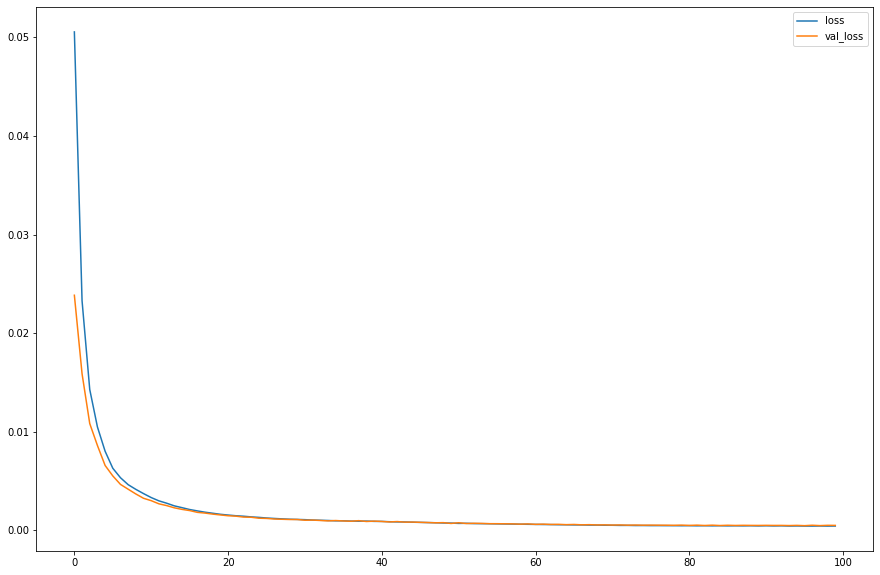

In [30]:
plt.figure(figsize = (15,10))

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(loc='best')
plt.show()

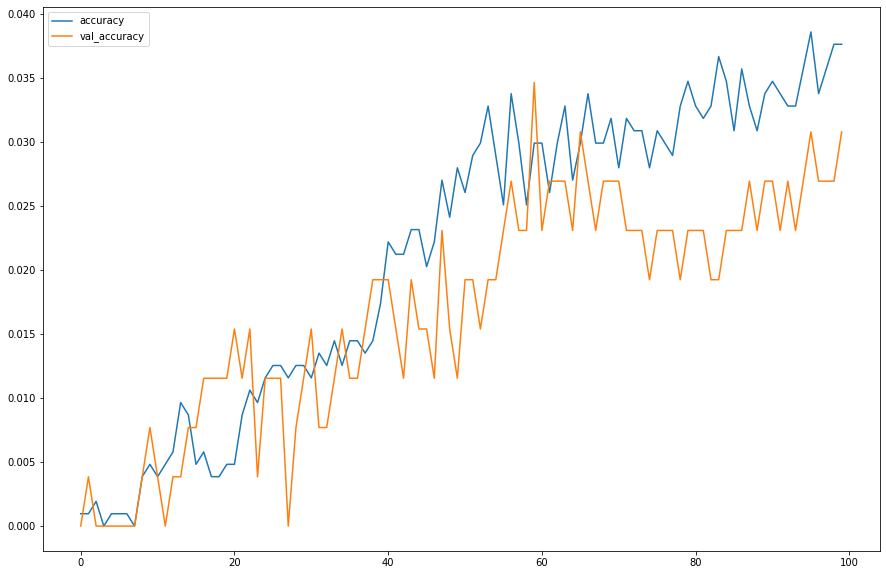

In [31]:
plt.figure(figsize = (15,10))

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend(loc='best')
plt.show()

### Predicting Test Results

In [32]:

X_test, void = processData(PCA_test,lookback,horizon,num_companies,horizon)
void, y_test = processData(array_test,lookback,horizon,num_companies,horizon) 
y_test = np.array([list(a.ravel()) for a in y_test])


Xt = model.predict(X_test)
Xt.shape

(19, 9812)

### Un-scaling the data and returning data to original shape
Because the results were scaled to train the model, the output is non sensible until we return the data into its original form

In [33]:
#Aux function 1
def do_inverse_transform(output_result,num_companies):
    #transform to input shape
    original_matrix_format = []
    for result in output_result:
        #do inverse transform
        original_matrix_format.append(scl.inverse_transform([result[x:x+num_companies] for x in range(0, len(result), num_companies)]))
    original_matrix_format = np.array(original_matrix_format)
    
    #restore to original shape
    for i in range(len(original_matrix_format)):
        output_result[i] = original_matrix_format[i].ravel()

    return output_result

In [34]:
#Aux function 2
def prediction_by_step_by_company(raw_model_output, num_companies):
    matrix_prediction = []
    for i in range(0,num_companies):
        matrix_prediction.append([[lista[j] for j in range(i,len(lista),num_companies)] for lista in raw_model_output])
    return np.array(matrix_prediction)

In [35]:
#Aux function 3
def target_by_company(raw_model_output, num_companies):
    matrix_target = [[] for x in range(num_companies)]
    
    for output in raw_model_output:
        for i in range (num_companies):
            for j in range(0,len(output),num_companies):
                matrix_target[i].append(output[i+j])
    return np.array(matrix_target)

In [36]:
Xt = do_inverse_transform(Xt, num_companies)
predictions = prediction_by_step_by_company(Xt, num_companies)
predictions.shape

(446, 19, 22)

In [37]:
Yt = do_inverse_transform(y_test, num_companies)

actuals = target_by_company(Yt, num_companies)
actuals.shape

(446, 418)

### Prediction Results on Test Data - Plot

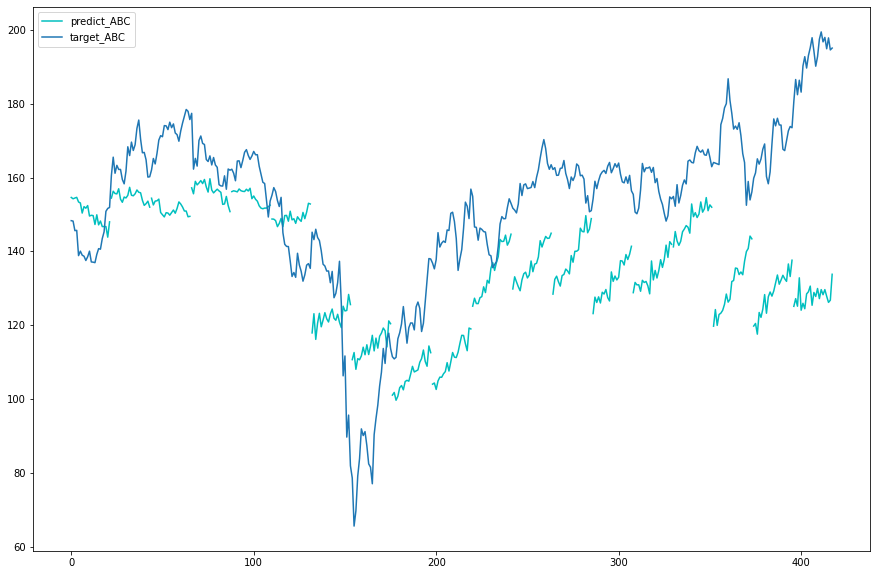

In [38]:
plt.figure(figsize = (15,10))

companies_to_show = [2] 
colors = ['r','g','c','m','y','k','w','b']
companies_names = ['A', 'AAPL', 'ABC', 'ABMD']
 
for id_company in companies_to_show:
    for i in range(0,len(predictions[id_company])):
        plt.plot([x + i*horizon for x in range(len(predictions[id_company][i]))], predictions[id_company][i], color=colors[id_company])
    plt.plot(0,predictions[id_company][0][0] ,color=colors[id_company], label='predict_{}'.format(companies_names[id_company])) #only to place the label

   

for id_company in companies_to_show:
    plt.plot(actuals[id_company], label='target_{}'.format(companies_names[id_company]))

plt.legend(loc='best')
plt.show()

In [39]:
full_PCA = np.concatenate((PCA_train,PCA_test),axis = 0)

In [40]:
X_all,void = processData(full_PCA,lookback,horizon,num_companies,horizon)
void,y_all = processData(scl.fit_transform(df_close),lookback,horizon,num_companies,horizon)
y_all = np.array([list(a.ravel()) for a in y_all])

In [41]:
Xt = model.predict(X_all)
Xt.shape

(90, 9812)

In [42]:
Xt = do_inverse_transform(Xt, num_companies)

predictions = prediction_by_step_by_company(Xt, num_companies)
predictions.shape

(446, 90, 22)

In [43]:
Yt = do_inverse_transform(y_all, num_companies)

actuals = target_by_company(Yt, num_companies)
actuals.shape

(446, 2244)

### Prediction Results on Full Data - Plot

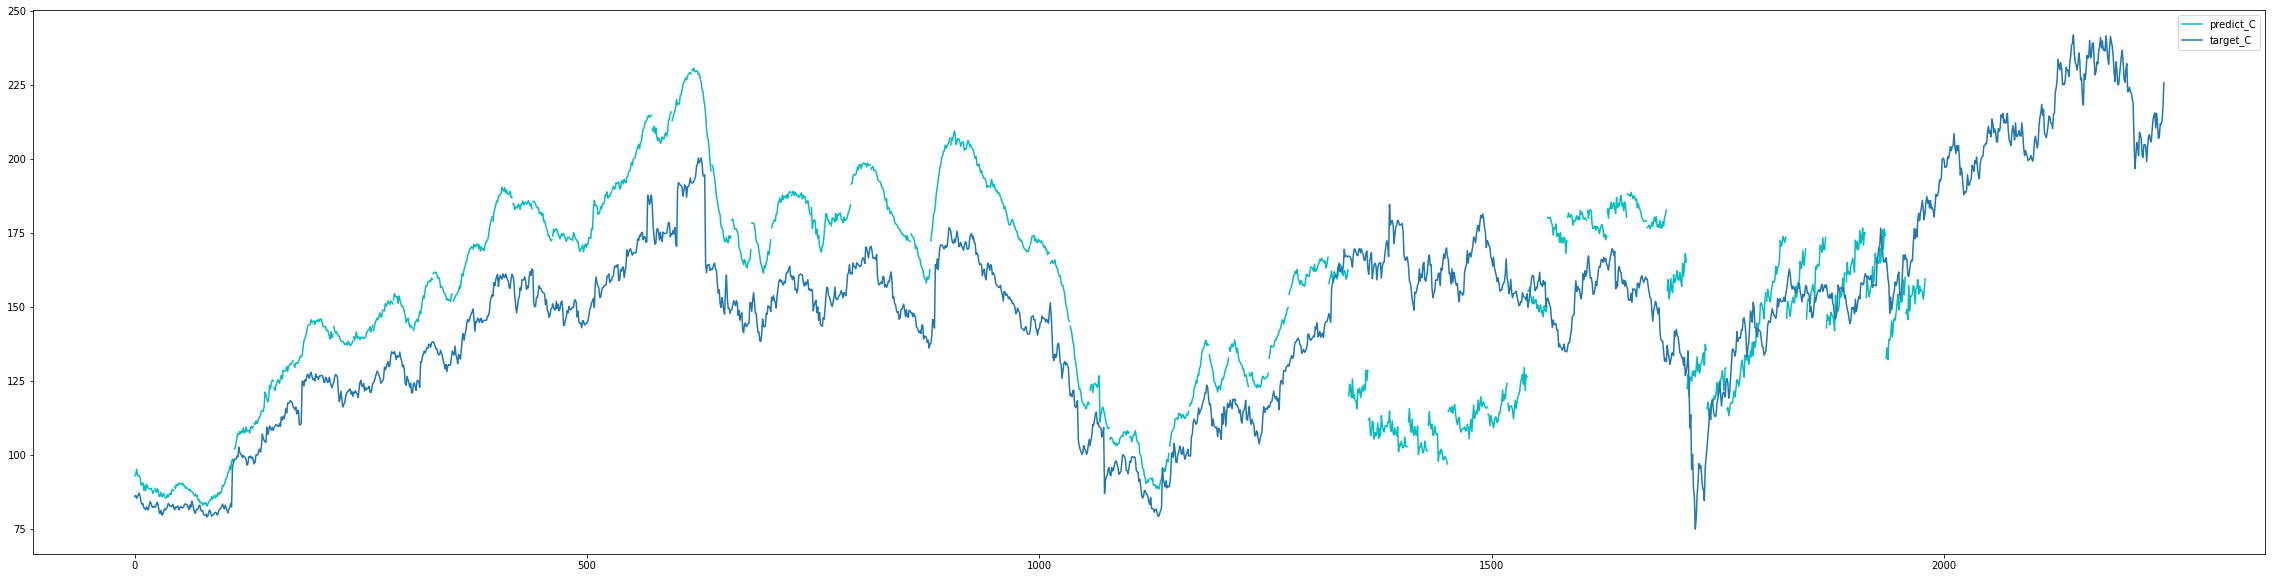

In [44]:
plt.figure(figsize = (40,10))

companies_to_show = [2] #Type a number between 0:4 to see 4 different companies
colors = ['r','g','c','m','y','k','w','b']
companies_names = ['A', 'B', 'C', 'D']

    
for id_company in companies_to_show:
    for i in range(0,len(predictions[id_company])):
        plt.plot([x + i*horizon for x in range(len(predictions[id_company][i]))], predictions[id_company][i], color=colors[id_company])
    plt.plot(0,predictions[id_company][0][0] ,color=colors[id_company], label='predict_{}'.format(companies_names[id_company])) #only to place the label

   

for id_company in companies_to_show:
    plt.plot(actuals[id_company], label='target_{}'.format(companies_names[id_company]))

plt.legend(loc='best')
plt.show()

##QQ-plot

# Stock Prices Predictions

In [45]:
predicted_prices = np.zeros((predictions.shape[1]*predictions.shape[2],predictions.shape[0]))
# actual_prices = []

for i in range(predictions.shape[0]):
  counter = 0
  for j in range(predictions.shape[1]):
    for z in range(predictions.shape[2]):
      predicted_prices[counter, i] = predictions[i,j,z]
      counter+=1

print(counter)

1980


In [46]:
#actuals_prices = actuals[:,:4488].T
actuals_prices = actuals[:,:1980].T

In [47]:
print(predicted_prices.shape)
print(actuals_prices.shape)
print(dates.shape)
#(lookback+1, )

(1980, 446)
(1980, 446)
(2516,)


In [48]:
(2516-lookback+1-258) #-4488

2007

In [49]:
# Need to remove certain days because we predict into the future. But, we aren't able to test these predicted days
# against actual days in our porfolio optimization

#actual_prices = pd.DataFrame(data = actuals_prices, columns = stocks,index = dates[lookback+1:5028-287])
#predicted_prices = pd.DataFrame(data = predicted_prices,columns=stocks, index = dates[lookback+1:5028-287])
actual_prices = pd.DataFrame(data = actuals_prices, columns = stocks,index = dates[lookback+1:2520-287])
predicted_prices = pd.DataFrame(data = predicted_prices,columns=stocks, index = dates[lookback+1:2520-287])

In [50]:
actual_prices

tic,A,AAL,AAP,AAPL,ABC,ABMD,ABT,ACN,ADBE,ADI,...,WYNN,XEL,XOM,XRAY,XRX,XYL,YUM,ZBH,ZBRA,ZION
date,,,,,,,,,,,,,,,,,,,,,
2013-05-15,31.452074,18.100000,86.120003,15.852143,54.959999,23.150000,37.049999,80.550003,44.040001,46.340000,...,142.139999,30.030001,91.110001,42.799999,23.504610,28.309999,50.431343,78.533981,46.599998,27.059999
2013-05-16,32.675251,18.809999,86.400002,15.316071,55.009998,23.219999,37.660000,80.760002,45.070000,46.689999,...,139.759995,30.330000,91.239998,42.529999,23.715414,28.600000,50.265995,78.631065,46.490002,26.969999
2013-05-17,32.181686,19.120001,85.419998,15.520714,54.400002,23.110001,36.830002,80.610001,44.560001,46.500000,...,139.360001,30.139999,90.699997,42.180000,23.083004,28.639999,50.057514,78.271843,46.169998,26.850000
2013-05-20,32.589413,19.010000,86.160004,15.473571,54.990002,23.330000,36.590000,82.239998,44.610001,47.020000,...,140.990005,30.420000,91.760002,42.279999,23.241108,28.930000,50.438534,78.000000,46.209999,27.389999
2013-05-21,33.147354,18.590000,86.519997,15.818929,54.820000,23.110001,37.810001,82.529999,44.290001,46.869999,...,143.110001,30.250000,92.519997,42.180000,23.610012,28.879999,50.654205,78.456314,46.189999,27.700001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-19,122.589996,24.700001,183.729996,120.529999,115.629997,298.859985,118.110001,266.890015,439.179993,149.449997,...,135.649994,62.400002,56.810001,63.049999,24.799999,104.169998,108.309998,154.262131,461.109985,57.299999
2021-03-22,122.690002,24.969999,186.000000,119.989998,115.919998,299.809998,120.250000,263.779999,441.500000,151.910004,...,135.479996,62.990002,56.490002,62.759998,24.790001,104.010002,107.959999,155.495148,459.950012,56.450001
2021-03-23,123.610001,23.830000,182.990005,123.389999,116.349998,306.160004,121.470001,265.200012,452.410004,154.500000,...,132.869995,63.750000,55.910000,62.439999,24.840000,102.430000,108.750000,155.572815,463.769989,55.279999


In [51]:
predicted_prices

tic,A,AAL,AAP,AAPL,ABC,ABMD,ABT,ACN,ADBE,ADI,...,WYNN,XEL,XOM,XRAY,XRX,XYL,YUM,ZBH,ZBRA,ZION
date,,,,,,,,,,,,,,,,,,,,,
2013-05-15,48.911514,18.379246,92.993141,21.913532,66.705635,21.804447,55.638577,142.467041,73.369759,62.369980,...,137.551697,34.008141,78.080406,39.612225,22.362192,34.080292,56.863979,91.438438,96.812080,31.973284
2013-05-16,50.172375,17.855078,93.299644,21.868214,66.426193,25.214874,56.863377,144.325790,68.536568,61.832661,...,135.668198,34.020428,78.695770,39.268990,22.531139,34.412289,57.251354,91.680878,92.975792,31.909096
2013-05-17,50.161278,18.230740,95.285133,21.107624,66.402924,23.690891,56.221107,146.206970,71.967964,61.267384,...,138.385284,33.927395,79.146309,39.659691,22.587601,34.076267,57.347034,92.056686,98.946640,32.397598
2013-05-20,48.916416,18.278784,93.291328,20.988586,66.174622,23.185917,57.250858,148.040283,77.600243,61.179779,...,137.623444,34.042076,79.286270,39.321918,22.778847,34.604965,58.568634,92.226402,95.628761,32.091408
2013-05-21,48.639515,18.114859,93.008286,20.551220,66.800423,23.540337,57.399475,145.983292,74.293198,61.349964,...,136.574554,33.752403,80.078300,39.325928,22.657961,33.887783,58.180386,92.374504,98.976685,32.409016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-19,66.620819,32.554604,155.755981,57.594105,92.838875,33.525166,71.356346,148.422318,163.765381,69.803711,...,194.507996,35.328911,82.498978,41.289028,33.956406,46.586720,58.727215,115.509178,213.877594,35.112579
2021-03-22,75.603416,32.358196,155.143051,55.590145,92.692726,28.971861,71.650352,144.236023,151.318314,72.602005,...,195.010300,36.017593,83.208641,42.001472,33.692116,47.710224,58.700260,120.231606,223.557785,35.045147
2021-03-23,68.833702,32.037521,152.666321,58.679256,96.015648,31.247559,69.918625,146.376999,154.193054,69.713936,...,190.066681,36.199730,83.130127,40.731930,33.587414,47.829433,57.602497,121.889252,209.180359,34.386787


In [52]:
from google.colab import drive
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [53]:
predicted_prices.to_csv(path + '/PCA_Predicted_Prices1.csv')
#!cp PCA_Predicted_Prices1.csv "drive/My Drive/Machine Learning Project/ML Section Exports"

In [54]:
actual_prices.to_csv(path +'/PCA_Actual_Prices1.csv')
#!cp PCA_Actual_Prices1.csv "drive/My Drive/Machine Learning Project/ML Section Exports"